In [ ]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-x8b8seqw
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-x8b8seqw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-8_3oll0k/pydoe_324221ac46124d10a5a0d6259f41ef39
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-8_3oll0k/pydoe_324221ac46124d10a5a0d6259f41ef39
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 316 kB 18.1 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=31872322eed53839966862b158856a1613d16c26f72cc5d38238e17b96905d66
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from pyDOE import lhs

from scipy.stats.qmc import Sobol, Halton

from benchmark.bbobbenchmarks import F13

from tqdm.notebook import tqdm, trange

import pandas as pd

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**5
verbose = False

space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
n_samples = 30000
samples = space.sample(n_samples)

doe_budget = 0.2
doe_size = int(doe_budget * max_FEs)

n_runs = 50
random_state = 1

f_name = 'f13'

In [ ]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s')


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30, ax=None):
  if ax is None:
    ax = plt.gca()
  plot(samples, values, ax=ax, outline=False) # plot surface
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      ax.scatter(x, y, color="magenta", s=marker_size)
      ax.annotate(str(i), h)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s', marker_size=marker_size)

def plot_mult_performance(samples, results, marker_size=30):
    _, axs = plt.subplots(2, 2)
    for (ax, result) in zip(axs.flatten(), results):
      ax.title.set_text(result['title'])
      func = F13(result['f_s'])
      values = func(samples)
      plot_ei_performance(func, samples, values, result['bo'], result, marker_size=marker_size, ax=ax)

In [ ]:
def make_optimizer(obj_func, doe):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_all(func_seed, doe, n=3, n_points=1000):
  regrets = []
  history = []
  precisions = []
  for seed in range(n):
    obj_func = F13(func_seed)
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    regret = yopt - obj_func.getfopt()
    points = lhs(dim, n_points) * 10 - 5
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    regrets.append(regret)
    history.append({'xopt': xopt, 'yopt': yopt, 'regret': regret, 'doe': doe, 'precision': precision, 'bo': bo, 'f_s': func_seed})
  return np.concatenate(regrets).mean(), np.mean(precisions), history

def compute_all_for(f, n=10):
  precisions, regrets, history = [], [], []
  for seed in trange(n):
    doe = f()
    r, p, h = compute_all(seed, doe, n=1, n_points=1000)
    precisions.append(p)
    regrets.append(r)
    history.append(h[0])
  return precisions, regrets, history

In [ ]:
def best_and_worst(history):
  def upd_min(t, c, f):
    if t is None:
      return c
    if t[f] > c[f]:
      return c
    return t
  def upd_max(t, c, f):
    if t is None:
      return c
    if t[f] < c[f]:
      return c
    return t
  best_regret, worst_regret = None, None
  best_precision, worst_precision = None, None
  for h in history:
    best_regret = upd_min(best_regret, h, 'regret')
    worst_regret = upd_max(worst_regret, h, 'regret')
    best_precision = upd_min(best_precision, h, 'precision')
    worst_precision = upd_max(worst_precision, h, 'precision')
  best_regret['title'] = 'min regret'
  worst_regret['title'] = 'max regret'
  best_precision['title'] = 'min precision'
  worst_precision['title'] = 'max precision'
  return best_regret, worst_regret, best_precision, worst_precision

In [ ]:
def additional_metrics(history):
  for h in history:
    f = F13(h['f_s'])
    y = f(h['xopt'])
    real_x = f._getxopt()
    d = np.linalg.norm(h['doe'] - real_x, axis=1)
    h['min_dist_to_opt'] = d.min()
    h['maxx_dist_to_opt'] = d.max()
    h['real_xopt'] = real_x
    h['real_yopt'] = f.getfopt()
    h['bo_history'] = h['bo'].history
  return history

# Latin hypercube sampling


In [ ]:
def generate_lhs():
  return lhs(2, doe_size) * 10 - 5

In [ ]:
lhs_precision, lhs_regret, lhs_history = compute_all_for(generate_lhs, n=n_runs)
print(f'LHS precision: {np.mean(lhs_precision)}, Uniform regret: {np.mean(lhs_regret)}')

  0%|          | 0/50 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
LHS precision: 1063678.560751017, Uniform regret: 19.674008509760398


LHS precision: min=144038.54322124136 max=5686739.494931202,  LHS regret: min=[0.61085667], max=[141.41776859]


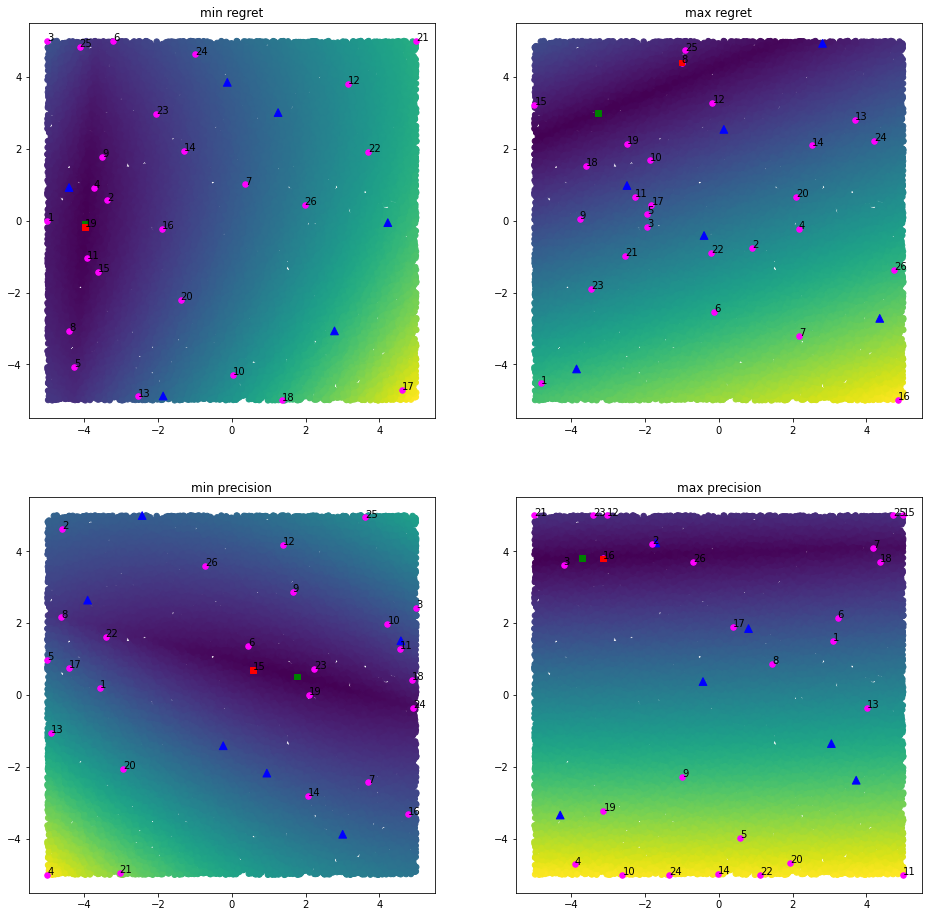

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision = best_and_worst(lhs_history)
print(f'LHS precision: min={lhs_best_precision["precision"]} max={lhs_worst_precision["precision"]},  LHS regret: min={lhs_best_regret["regret"]}, max={lhs_worst_regret["regret"]}')
plot_mult_performance(samples, (lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision), marker_size=30)

In [ ]:
lhs_df = pd.DataFrame(additional_metrics(lhs_history)).drop(['title', 'bo'], axis=1)
lhs_df.to_csv(f'lhs_doe_{f_name}.csv')

In [ ]:
lhs_best_precision['precision'], lhs_best_precision['regret'], lhs_best_precision['f_s']

(144038.54322124136, array([25.16374297]), 26)

In [ ]:
lhs_best_regret['precision'], lhs_best_regret['regret'], lhs_best_precision['f_s']

(1179217.9472176791, array([0.61085667]), 26)

# Uniform

In [ ]:
def generate_uniform():
  return np.random.uniform(-5, 5, (doe_size, 2))

In [ ]:
uniform_precision, uniform_regret, uniform_history = compute_all_for(generate_uniform, n=n_runs)

  0%|          | 0/50 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


In [ ]:
print(f'Uniform precision: {np.mean(uniform_precision)}, Uniform regret: {np.mean(uniform_regret)}')

Uniform precision: 1054852.858160703, Uniform regret: 16.187690853590528


Uniform precision: min=156083.37105705656 max=5684641.148827367,  Uniform regret: min=[0.8701587], max=[58.66516239]


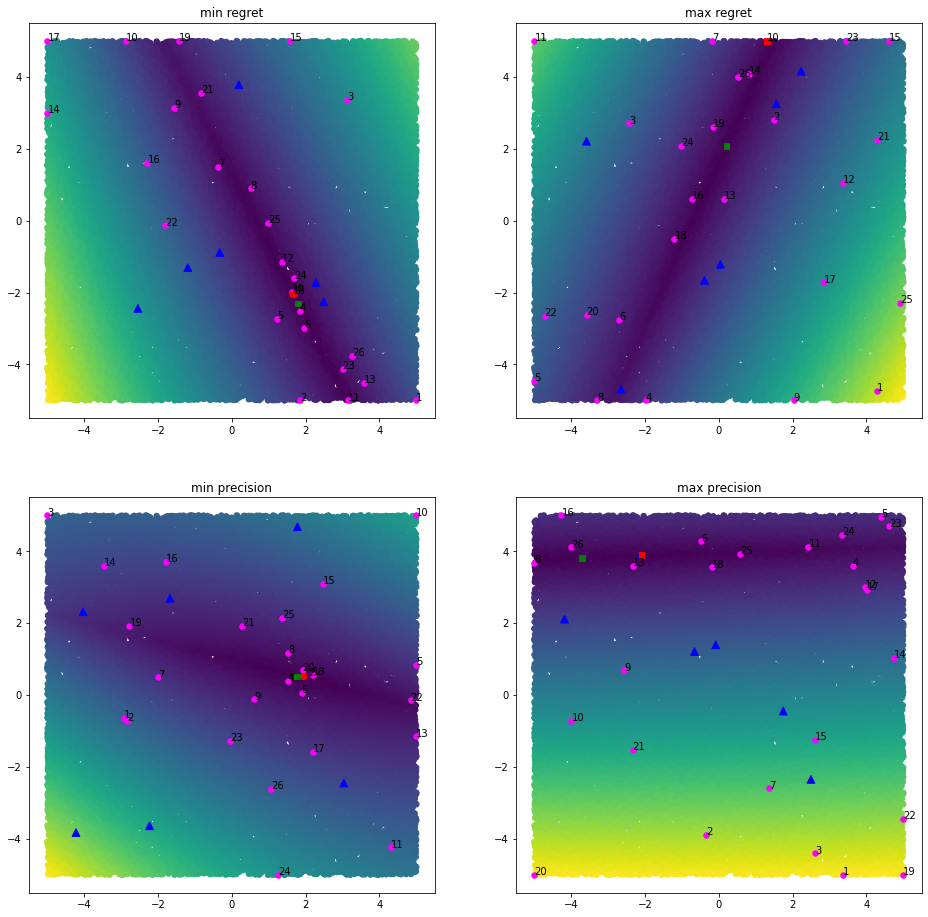

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision = best_and_worst(uniform_history)
print(f'Uniform precision: min={uniform_best_precision["precision"]} max={uniform_worst_precision["precision"]},  Uniform regret: min={uniform_best_regret["regret"]}, max={uniform_worst_regret["regret"]}')
plot_mult_performance(samples, (uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision), marker_size=30)

In [ ]:
uniform_df = pd.DataFrame(additional_metrics(uniform_history)).drop(['title', 'bo'], axis=1)
uniform_df.to_csv(f'uniform_doe_{f_name}.csv')

In [ ]:
uniform_best_precision['precision'], uniform_best_precision['regret'], uniform_best_precision['f_s']

(156083.37105705656, array([9.74874882]), 26)

In [ ]:
uniform_best_regret['precision'], uniform_best_regret['regret'], uniform_best_regret['f_s']

(567955.1407217889, array([0.8701587]), 0)

# Sobol

In [ ]:
def generate_sobol():
  return Sobol(dim).random(doe_size) * 10 - 5

In [ ]:
sobol_precision, sobol_regret, sobol_history = compute_all_for(generate_sobol, n=n_runs)

  0%|          | 0/50 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


In [ ]:
f'Sobol precision: {np.mean(sobol_precision)}, Sobol regret: {np.mean(sobol_regret)}'

'Sobol precision: 1059598.6015626087, Sobol regret: 21.5709819952492'

Sobol precision: min=151134.21040501154 max=5684241.947626125,  Sobol regret: min=[1.75942838], max=[72.26563843]


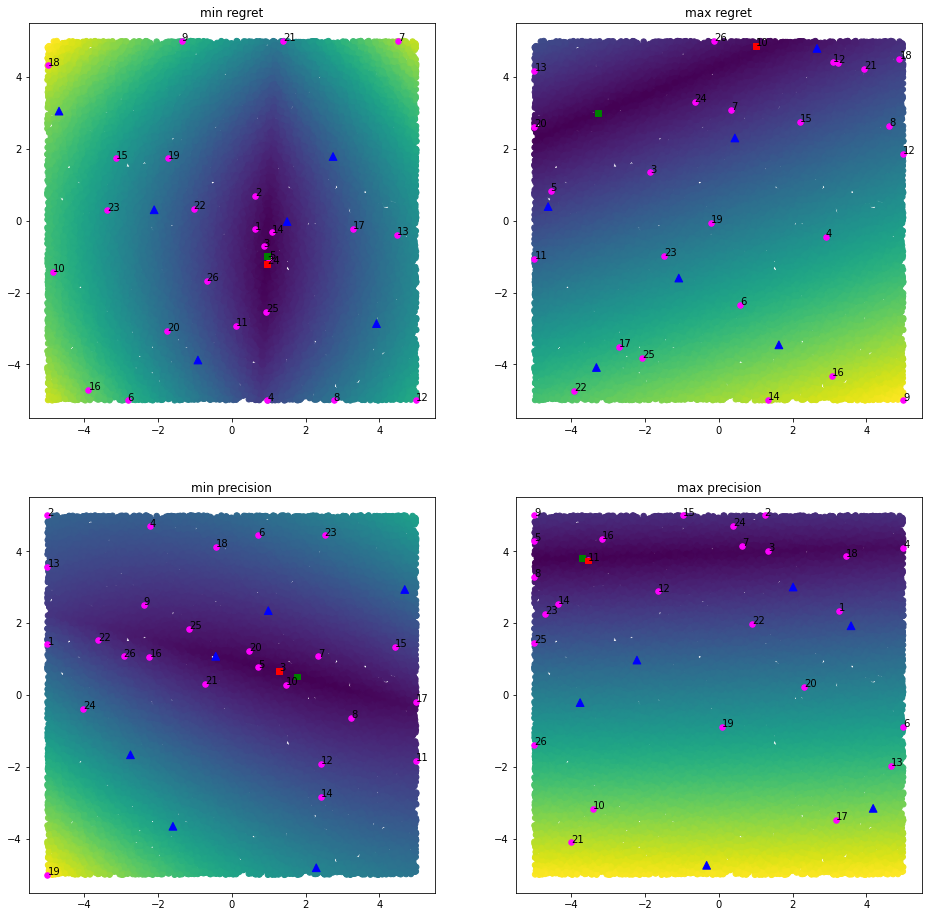

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision = best_and_worst(sobol_history)
print(f'Sobol precision: min={sobol_best_precision["precision"]} max={sobol_worst_precision["precision"]},  Sobol regret: min={sobol_best_regret["regret"]}, max={sobol_worst_regret["regret"]}')
plot_mult_performance(samples, (sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision), marker_size=30)

In [ ]:
sobol_df = pd.DataFrame(additional_metrics(sobol_history)).drop(['title', 'bo'], axis=1)
sobol_df.to_csv(f'sobol_doe_{f_name}.csv')

In [ ]:
sobol_best_precision['precision'], sobol_best_precision['regret'], sobol_best_precision['f_s']

(151134.21040501154, array([4.90396663]), 26)

In [ ]:
sobol_best_regret['precision'], sobol_best_regret['regret'], sobol_best_regret['f_s']

(195890.59865735407, array([1.75942838]), 36)

# Halton

In [ ]:
def generate_halton():
  return Halton(dim).random(doe_size) * 10 - 5

In [ ]:
halton_precision, halton_regret, halton_history = compute_all_for(generate_halton, n=n_runs)

  0%|          | 0/50 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...


In [ ]:
f'Halton precision: {np.mean(halton_precision)}, Halton regret: {np.mean(halton_regret)}'

'Halton precision: 1058483.5819720034, Halton regret: 17.564901987695226'

Halton precision: min=151286.93460171606 max=5682277.58367889,  Halton regret: min=[0.80957649], max=[48.69416231]


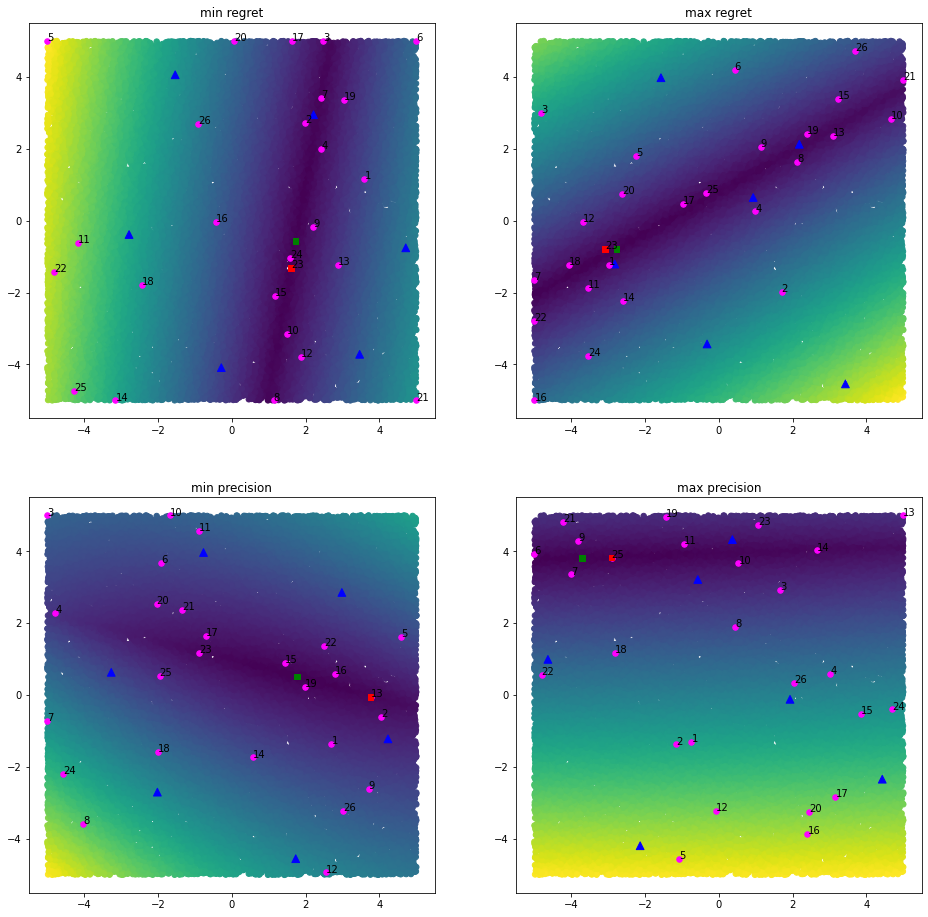

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision = best_and_worst(halton_history)
print(f'Halton precision: min={halton_best_precision["precision"]} max={halton_worst_precision["precision"]},  Halton regret: min={halton_best_regret["regret"]}, max={halton_worst_regret["regret"]}')
plot_mult_performance(samples, (halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision), marker_size=30)

In [ ]:
halton_df = pd.DataFrame(additional_metrics(halton_history)).drop(['title', 'bo'], axis=1)
halton_df.to_csv(f'halton_doe_{f_name}.csv')

In [ ]:
halton_best_precision['precision'], halton_best_precision['regret'], halton_best_precision['f_s']

(151286.93460171606, array([28.89062353]), 26)

In [ ]:
halton_best_regret['precision'], halton_best_regret['regret'], halton_best_regret['f_s']

(1078264.0035435238, array([0.80957649]), 37)

# Compare

In [ ]:
all_history = (lhs_history, uniform_history, sobol_history, halton_history)
all_titles = ("lhs", "uniform", "sobol", "halton")

## Regret boxplots

Text(0.5, 1.0, 'Regret')

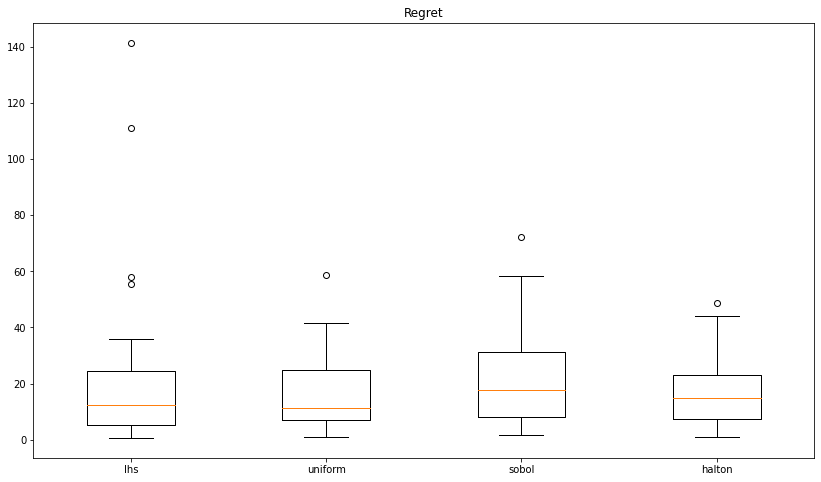

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate([result['regret'] for result in history]) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Regret')

Text(0.5, 1.0, 'Log regret')

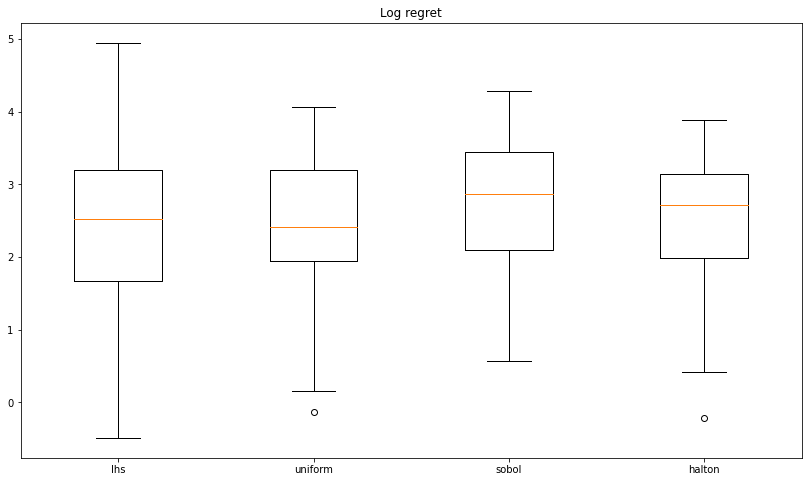

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate([np.log(result['regret']) for result in history]) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Log regret')

## Precision boxplots

Text(0.5, 1.0, 'Precision')

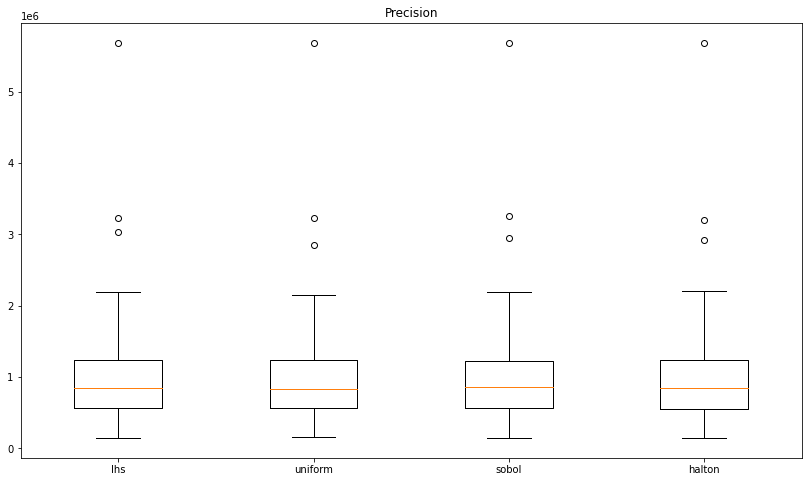

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[result['precision'] for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Precision')

Text(0.5, 1.0, 'Log precision')

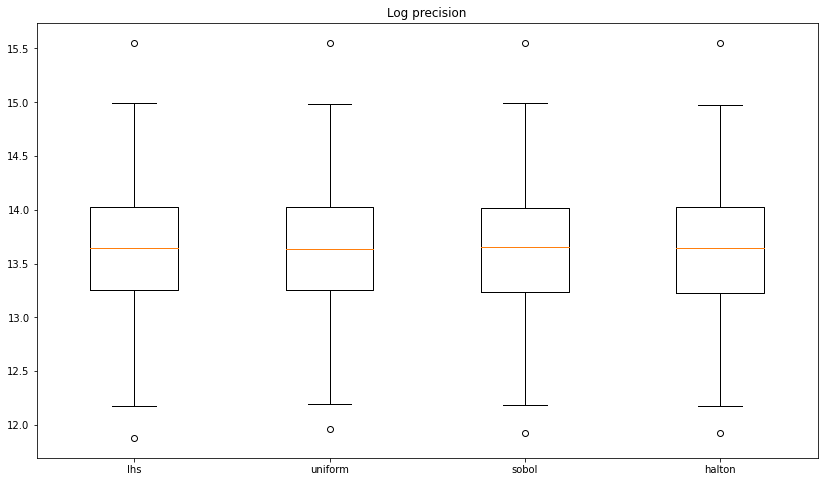

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[np.log(result['precision']) for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Log precision')

## Regret-precision dep

Text(0, 0.5, 'log regret')

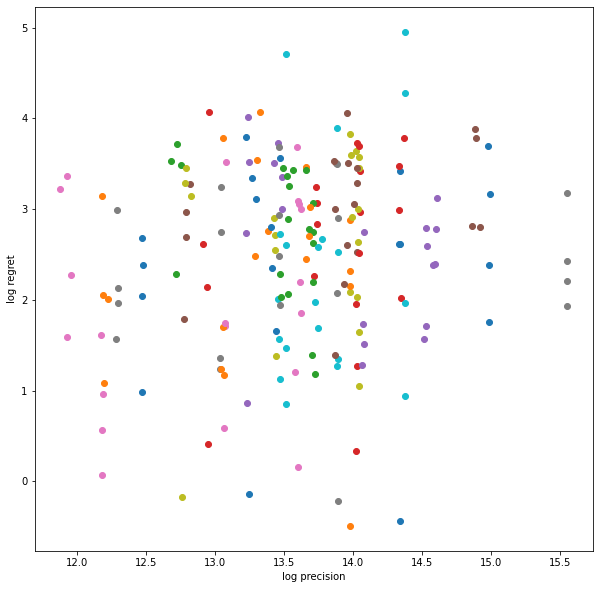

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
for info in (lhs_history + uniform_history + sobol_history + halton_history):
  plt.scatter(np.log(info['precision']), np.log(info['regret']))
plt.xlabel('log precision')
plt.ylabel('log regret')